# Import Package

In [1]:
%matplotlib inline
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import pickle

import gymnasium as gym
import random
from bayes_opt import BayesianOptimization

# Lunar Lander environment

In [2]:
seed = 543
def fix(env, seed):
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
env = gym.make('LunarLander-v2' ,render_mode='rgb_array')
fix(env, seed) # fix the environment Do not revise this !!!

In [3]:
env.reset()

(array([-7.7629091e-05,  1.4208617e+00, -7.8776376e-03,  4.4184282e-01,
         9.6731499e-05,  1.7843659e-03,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

# PPO Agent

**If you DON'T want to OVERWRITE your previous results, increment the N by 1!**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
N = 5

cuda


## Class: Memory

store the actions, states, rewards, is_termminal, and log probabilities

In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

## Class: ActorCritic

### 2 fully connected networks
1. actor/action layer: input the states, follow the policy and yields an action
2. critic/value layer: input the states, evaluate the current estimated rewards

### act function

Generate a probability distribution of the actions using action layer taking state as the input, sample one action and store these information in the memory.

### evaluate function

Take a state as input and generate action probability distribution, calculate the entropy of this distribution and evaluate the log probability of the given action. Use the critic to evaluate the expected rewards under current state. Return all these values.

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, n_latent_var),
                nn.ReLU(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )

        # critic
        self.value_layer = nn.Sequential(
               nn.Linear(state_dim, 128),
               nn.ReLU(),
               nn.Linear(128, n_latent_var),
               nn.ReLU(),
               nn.Linear(n_latent_var, 1)
               )
    
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

## PPO agent

Some explaination of concepts and functions:

### gamma

If close to 1, future rewards will be considered more
If close to 0, current rewards wiil take more proportion

### state_values

The output of the critic, which evaluates the state and give an expected future reward

### rewards

The static list of discounted rewards calculated by the data in old trajectory (when adopting old policy)

### advantages = rewards - state_values.detach()

How better the old policy perform than current policy. if positive, actual reward is higher than state value, it is better to stick to current action, vice versa

### update()

Calling this function will update the networks for K epochs.

### step()

Record the information of one step the agent just took in the environment. Every 1000(update_timestep) steps reached will trigger update(). Therefore, the update frequency is guaranteed.

In [7]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, n_latent_var,update_timestep, lr, betas, gamma, K_epochs, eps_clip, c1, c2):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.update_timestep = update_timestep
        self.timestep = 0
        self.memory = Memory()

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()
        self.update_cnt = 0

        self.c1 = c1
        self.c2 = c2


    def update(self):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.stack(self.memory.states).detach().to(device)
        old_actions = torch.stack(self.memory.actions).detach().to(device)
        old_logprobs = torch.stack(self.memory.logprobs).detach().to(device)

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values 
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss 
            advantages = rewards - state_values.detach()
            
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages # clip to avoid large difference between samples
            loss = -torch.min(surr1, surr2)  + self.c1*self.MseLoss(state_values, rewards) + self.c2*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear_memory()

    def step(self, reward, done):
        self.timestep += 1 
        # Saving reward and is_terminal:
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)

        # update the policy per "update_timestep"
        if self.timestep % self.update_timestep == 0:
            self.update()
            self.memory.clear_memory()
            self.update_cnt += 1

    def act(self, state):
        return self.policy_old.act(state, self.memory)
    
    def train(self):
        self.policy.train()
        self.policy_old.train()

    def eval(self):
        self.policy.eval()
        self.policy_old.eval()

## Helping functions

In [8]:
def moving_average(total_rewards):
    if len(total_rewards) == 0:
        return 0
    if len(total_rewards) < 99:
        return np.mean(total_rewards)
    else:
        return np.mean(total_rewards[-100:])
    
def reward_shaping(pre_state, state, type):
    if (type == "center"):
        pre_shaping = -20*np.abs(pre_state[0])
        shaping = -20*np.abs(state[0])
    if (type == "horizontal"):
        pre_shaping = -1*np.abs(pre_state[4])
        shaping = -1*np.abs(state[4])
    if (type == "both"):
        pre_shaping = -10*np.abs(pre_state[0])-5*abs(pre_state[4])
        shaping = -10*np.abs(state[0])-5*abs(state[4])
    if (type == "none"):
        pre_shaping, shaping = 0, 0
    return shaping - pre_shaping

## Training function

### It will take the agent as input and train it until some standard is satisfied. Then return the some results data as a disctionary.

### You can set some parameters when calling this training function:
1. reward_mode
   
    When doing experiment with reshape the reward function, this could be set to "center", "horizontal" or "both". When training normally, set this to "none".
3. target_score
   
    If moving average score in training over previous 100 episodes reaches this score, the training will be terminated.
4. target_success_rate
   
    If the landing success rate over previous 300 episodes reaches this value, the training will be terminated.
6. max_episodes
   
    You cannot train more than this number of episodes.
8. max_steps
   
    Use for debug.

### Return value:
1. total_rewards

    The list of rewards that the lander was rewarded in every episode during the training process.
2. moving_average_rewards

    Use a sliding window of size 100 to show the average rewards the agent got through training.
3. final_rewards

    The list of the final rewards in each episode, which indicates whether the lander had successfully landed. If the final reward is 100, it lands successfully; if -100, it crashes in the end.

5. num_episodes

    The number of episodes.
6. success_rate

    This is the success landing rate of last 300 episodes. So, it changes across the training process. In the end, it is returned as the success rate of last 300 episodes.

In [9]:
def TrainOnce(c2, eps_clip, agent, reward_mode = "none", target_score = 200, target_success_rate = 0.9, max_episodes=2000, max_steps=900):
    agent.train()
    print(f"Training with c2: {c2}, eps_clip: {eps_clip}")
    total_rewards = []
    final_rewards = []
    moving_average_rewards = []
    num_episodes = 0
    success_rate = 0
    while True:
        num_episodes += 1
        state = env.reset()[0]
        total_reward = 0
        total_shaped_reward = 0
        step = 0
        # update_cnt = agent.update_cnt
        while True:
            step +=1
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            shaped_reward = reward + reward_shaping(state, next_state, reward_mode)
            total_shaped_reward += shaped_reward # use the shaped reward to train
            agent.step(shaped_reward, done)
            
            state = next_state
            # if done or step >= max_steps:
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        moving_average_rewards.append(moving_average(total_rewards))
        success_rate = final_rewards[-100:].count(100) / 100

        if (num_episodes % 100 == 0):
            print(f"Update Count: {agent.update_cnt}, average rewards: {moving_average_rewards[-1]}, episode: {num_episodes}, success rate: {success_rate}")
        
        # finish the training if any one condition is reached
        if (moving_average(total_rewards) >= target_score):
            print(f"Target score reached in {num_episodes} episodes!")
            break
        if (success_rate >= target_success_rate):
            print(f"Target success rate reached in {num_episodes} episodes!")
            break
        if (num_episodes >= max_episodes):
            print(f"Max episodes {max_episodes} reached!")
            break

    training_result = {
        "total_rewards": total_rewards,
        "moving_average_rewards": moving_average_rewards,
        "final_rewards": final_rewards,
        "num_episodes": num_episodes,
        "success_rate": success_rate
    }
    return training_result

## Evaluation function

Switch the model to evaluate mode and test for ``eval_num`` (500 by defaults) rounds of games, and calculate the related data. Return a dictionary including related information, where the definition is similar to those in Training function.

In [10]:
def EvaluateOnce(agent, eval_num = 500):
    agent.eval()
    test_total_rewards = []
    test_final_rewards = []
    success_rate = 0
    prg_bar = tqdm(range(eval_num))
    for i in prg_bar:
        state = env.reset()[0]
        total_reward = 0
        step = 0
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            step += 1
            if (step>3000):
                done = True
        test_total_rewards.append(total_reward)
        test_final_rewards.append(reward)
    success_rate = test_final_rewards.count(100) / eval_num
    print(f"Test success rate {success_rate} over {eval_num} games")
    eval_result = {
        "test_total_rewards": test_total_rewards,
        "test_final_rewards": test_final_rewards,
        "success_rate": success_rate
    }
    return eval_result

# Bayesian Optimization

## Use BayesianOptimization to find the best pair of c2 and eps_clip

Modify the "if" condition to enable or disable the optimization process

In [11]:
state_dim = 8 
action_dim = 4 
n_latent_var = 64
update_timestep = 1000
c1 = 0.5
lr = 0.003
betas = (0.9, 0.999)
gamma = 0.99
K_epochs = 4

c2=-0.006031556122828571
eps_clip=0.220106198572796
if (False):
    p_bounds = {'c2': (-0.012, -0.006), 'eps_clip': (0.1,0.3)}

    def PPO_fn(c2, eps_clip):
        agent = PPOAgent(state_dim,action_dim,n_latent_var,update_timestep,lr,betas,gamma,K_epochs,eps_clip,c1,c2)
        training_result = TrainOnce(c2, eps_clip, agent, target_score=200)
        return -training_result["num_episodes"]
    HyperParamOptimizer = BayesianOptimization(
        f=PPO_fn,
        pbounds=p_bounds,
        random_state=1
    )
    HyperParamOptimizer.probe(
        params=[-0.008, 0.20],
        lazy=True
    )
    HyperParamOptimizer.maximize(
        init_points=2,
        n_iter=7
    )
    print(HyperParamOptimizer.max)
    c2 = HyperParamOptimizer.max['params']['c2']
    eps_clip = HyperParamOptimizer.max['params']['eps_clip']


# Train a excellent model

## Set your requirements, and keep training until one of them are satisfied.

Here you can set your expected target score or target success rate. It is very likely that the model can satisfy that goal when testing.

For average score above 250 and success rate above 95%, it is hard to guarantee to obtain the result.

In [12]:
agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
excellent_result = TrainOnce(c2, eps_clip, agent, target_score=250, target_success_rate=0.90, max_episodes=5000, max_steps=1000)

Training with c2: -0.006031556122828571, eps_clip: 0.220106198572796
Update Count: 9, average rewards: -150.42289864146062, episode: 100, success rate: 0.0
Update Count: 43, average rewards: -109.35090692502197, episode: 200, success rate: 0.01
Update Count: 53, average rewards: -76.14485781574781, episode: 300, success rate: 0.01
Update Count: 64, average rewards: -33.042283822964855, episode: 400, success rate: 0.0
Update Count: 103, average rewards: 81.93633157169121, episode: 500, success rate: 0.45
Update Count: 144, average rewards: 108.66090582589364, episode: 600, success rate: 0.65
Update Count: 180, average rewards: 177.67763214153743, episode: 700, success rate: 0.75
Update Count: 212, average rewards: 144.40313283285153, episode: 800, success rate: 0.63
Update Count: 246, average rewards: 101.46894091936105, episode: 900, success rate: 0.68
Update Count: 275, average rewards: 143.0227816894068, episode: 1000, success rate: 0.72
Update Count: 310, average rewards: 158.117936

## Save the model

In [13]:
torch.save(agent.policy_old.state_dict(), f'./trained_models/PPO_LunarLander_{N}.pth')

# Load and evaluation

## load the model

In [14]:
state_dict = torch.load(f'./trained_models/PPO_LunarLander_{N}.pth')
model = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep,lr,betas,gamma,K_epochs,eps_clip,c1,c2)
model.policy.load_state_dict(state_dict)
model.policy_old.load_state_dict(state_dict)

<All keys matched successfully>

## Evaluate for few hundred times

In [15]:
eval_result = EvaluateOnce(model, 300)

  0%|          | 0/300 [00:00<?, ?it/s]

Test success rate 0.9766666666666667 over 300 games


## Store the evaluation result and training result

In [16]:
total_rewards = excellent_result['total_rewards']
final_rewards = excellent_result['final_rewards']
moving_average_rewards = excellent_result['moving_average_rewards']
test_total_rewards = eval_result['test_total_rewards']
test_final_rewards = eval_result['test_final_rewards']
success_rate = eval_result['success_rate']
data = {'total_rewards': total_rewards, 'final_rewards': final_rewards, 'moving_average_rewards': moving_average_rewards, 'test_total_rewards': test_total_rewards, 'test_final_rewards': test_final_rewards, 'success_rate': success_rate}

with open(f'./results/PPO_Result_{N}.pkl', 'wb') as f:
    pickle.dump(data, f)

## DEMO

### Demo Saving Function

In [17]:
!mkdir demo_gifs/trial{N}

In [18]:
def save_demo(agent, num=10, mode = 'trail'):
    agent.eval()
    fig = plt.figure()
    total_rewards = []

    for i in range(num):
        ims = []
        agent.eval()
        actions = []
        state = env.reset()[0]
        total_reward = 0
        done = False
        step = 0
        while not done :
            step +=1
            action = model.act(state)
            actions.append(action)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            im = plt.imshow(env.render(), animated=True)
            ims.append([im])
        total_rewards.append(total_reward)
        ani = animation.ArtistAnimation(fig, ims, interval=25, blit=True, repeat_delay=1000)
        if mode=='trail':
            ani.save(f'./demo_gifs/trial{N}/demo_{N}_{i}.gif')
        if mode=='reward shaping':
            ani.save(f'./demo_gifs/trial{N}/reward_shaping_{N}_{i}.gif')
        if mode=='compare':
            ani.save(f'./demo_gifs/trial{N}/compare_{N}_{i}.gif')


### Save 10 demos for model loaded just now

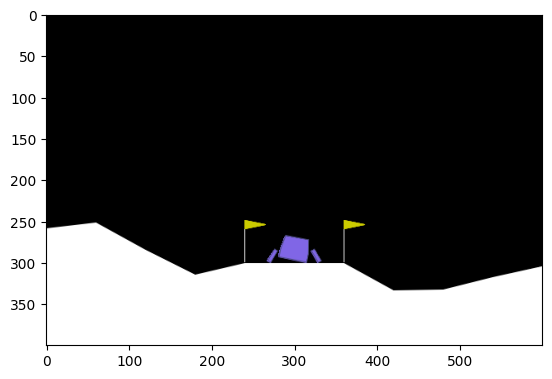

In [19]:
save_demo(model, 10, 'trail')

# Reward Shaping

In [20]:
!mkdir demo_gifs/reward_shaping{N}

## Training process

In [21]:
fix(env, 234)
r_s_agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
training_result_rs = TrainOnce(c2, eps_clip, r_s_agent, reward_mode="center")

Training with c2: -0.006031556122828571, eps_clip: 0.220106198572796
Update Count: 13, average rewards: -200.17757427139415, episode: 100, success rate: 0.0
Update Count: 34, average rewards: -196.76633538186937, episode: 200, success rate: 0.01
Update Count: 44, average rewards: -94.33455936939134, episode: 300, success rate: 0.0
Update Count: 69, average rewards: -38.74023207553534, episode: 400, success rate: 0.03
Update Count: 97, average rewards: -31.71977591105826, episode: 500, success rate: 0.07
Update Count: 127, average rewards: 9.786768189378106, episode: 600, success rate: 0.23
Update Count: 159, average rewards: 44.871033853904954, episode: 700, success rate: 0.39
Update Count: 196, average rewards: 69.77595729733954, episode: 800, success rate: 0.48
Update Count: 233, average rewards: 26.872491974966703, episode: 900, success rate: 0.44
Update Count: 268, average rewards: 29.804316096140454, episode: 1000, success rate: 0.42
Update Count: 299, average rewards: 44.27806827

In [22]:
# In case you want to save the pickle file, uncomment these.
# with open('training_result_rs.pkl', 'wb') as f:
#     pickle.dump(training_result_rs, f)

## Compare to normal process

In [ ]:
normal_agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
training_result_normal = TrainOnce(c2, eps_clip, normal_agent, reward_mode="none")

Training with c2: -0.006031556122828571, eps_clip: 0.220106198572796
Update Count: 8, average rewards: -190.01953416810983, episode: 100, success rate: 0.0
Update Count: 16, average rewards: -145.74660011663104, episode: 200, success rate: 0.0


In [ ]:
# In case you want to save the pickle file, uncomment these.
# with open('training_result_normal.pkl', 'wb') as f:
#     pickle.dump(training_result_normal, f)

In [ ]:
plt.figure(figsize=(9,6))
plt.title("Reward Shaping Helps to Learn", fontsize=20)
moving_average_rewards1 = training_result_normal['moving_average_rewards']
plt.plot(moving_average_rewards1, color=(147/255,103/255,153/255), label='Normal')
moving_average_rewards2 = training_result_rs['moving_average_rewards']
plt.plot(moving_average_rewards2, color="green", label='Reward Shaping')
plt.xlabel('Episode Needed')
plt.ylabel('Average Rewards')
plt.axhline(y=200, color='r', linestyle='--')

x1 = len(moving_average_rewards1)
x2 = len(moving_average_rewards2)
plt.plot([x1,x1], [-400,200], color = "grey", linestyle='--')
plt.plot([x2,x2], [-400,200], color = "grey", linestyle='--')
plt.text(x1+10,0, f'{x1} episodes')
plt.text(x2+10,0, f'{x2} episodes')

plt.ylim(-400, 400)
plt.xlim(0, 1300)
plt.legend()

plt.show()